In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import pandas as pd

from PIL import Image
import glob
import scipy.stats as stats
import cv2

from skimage.filters import sobel
from skimage import segmentation

In [5]:
def convert_and_save_binary_mask(filename):
    '''filename is a mask that has 3 identical channels. The function convert it to single channel,
       and then convert it to a binary mask by watershed transform. '''
    mask=Image.open(filename).convert('L')
    mask_np = np.array(mask)
    
    elevation_map = sobel(mask_np)
    markers = np.zeros_like(mask_np)
    markers[mask_np < 76.5] = 1
    markers[mask_np > 185] = 2
    segmentation_mask = segmentation.watershed(elevation_map, markers)
    
    binary_mask = (segmentation_mask == 2)*255
    cv2.imwrite('data/masks_0_255/'+filename[11:], np.uint8(binary_mask))

In [6]:
mask_list = []
for filename in glob.glob('data/masks/*.jpg'):
    convert_and_save_binary_mask(filename)

In [44]:
import numpy as np # linear algebra
import os
import skimage, os
from skimage.morphology import binary_erosion, binary_closing, disk
from skimage.filters import roberts, sobel
from skimage.measure import label,regionprops
from skimage.segmentation import clear_border
from scipy import ndimage as ndi

def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 151
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [52]:
def preprocess_and_save_img(filename):
    img_np = np.array(Image.open(filename))[:,:,0]
    preprocessed_img = get_segmented_lungs(img_np)
    cv2.imwrite('data/preprocessed_img/'+filename[20:], preprocessed_img)

In [59]:
for filename in glob.glob('data/imgs-3-channel/*.jpg'):
    preprocess_and_save_img(filename)

### 1. seems like this preprocessing only works with a subset of the CT scans that are grayish
### 2. need filtering out those preprocessed images and get their corresponding masks
### 3. CT scans with darker background should be preprocessed using a different threshold for binary mask
### 4. the function below allows adjustable thresholding during preprocessing

In [68]:
for filename in glob.glob('data/preprocessed_img_that_remains/*.jpg'):
    mask = np.array(Image.open('data/masks_0_255/'+filename[35:]))
    cv2.imwrite('data/masks_0_255_that_remains/'+filename[35:], mask)

In [79]:
def get_segmented_lungs_with_adjustable_binary(im, binary_threshold, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < binary_threshold
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

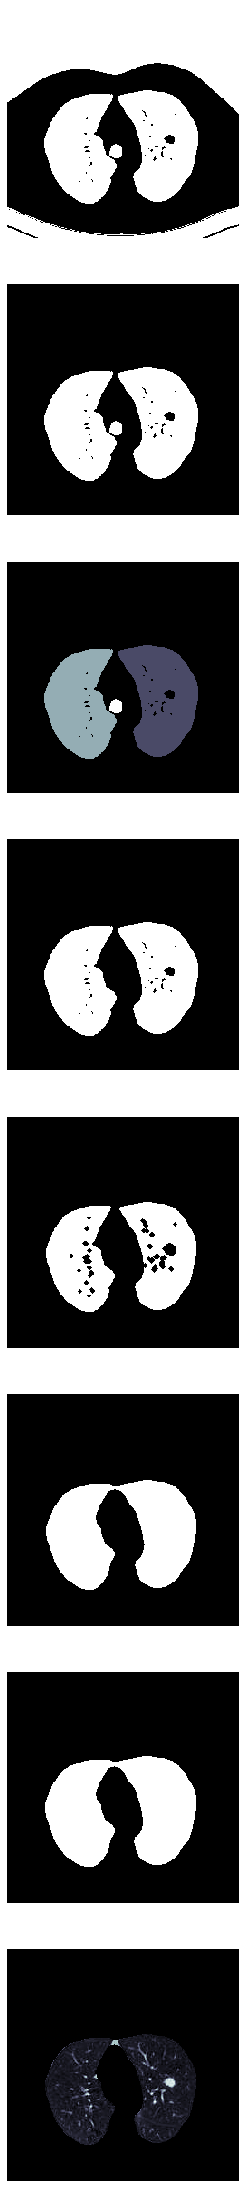

In [96]:
im_1 = np.array(Image.open(glob.glob('data/imgs-3-channel/*.jpg')[11]))[:,:,0]
img_1_preprocessed = get_segmented_lungs_with_adjustable_binary(im_1, 75, plot=True)

### The cell below tests for a threshold that gives a binary mask with clear border of lungs
### The threshold varies depending on lighter/darker background

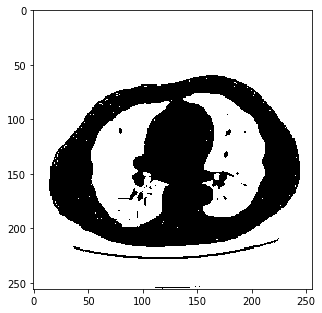

In [22]:
binary = tmp_img[:,:,0] < 151
f, plots = plt.subplots(1, 1, figsize=(5, 40))
plots.imshow(binary, cmap=plt.cm.bone) 